We used USO as the oil benchmark because it correlates at 96% with the crude oil movements

In [40]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas_datareader import data as wb

In [50]:
Ticker=['XOM','CVX']
print(Ticker,len(Ticker))
df=pd.DataFrame()
for i in Ticker:
    print(i)
    try:
        df[i]=wb.DataReader(i,'yahoo', start='2010-01-01')['Adj Close']
    except:
        print('{} not available'.format(i))

['XOM', 'CVX'] 2
XOM
CVX


In [74]:
def zscoring(df,X,s):
    
    sample = np.log(df[s-60:s].dropna(axis=1)/df[s-60:s].dropna(axis=1).shift(1)).dropna()
    
    factors = np.log(X[s-60:s]/X[s-60:s].shift(1)).dropna()
   
    # Add 1's to fit the linear regression (intercept)
    factors = sm.add_constant(factors)
    
    # Train Ordinary Least Squares linear model for each stock
    
    OLSmodels = {ticker: sm.OLS(sample[ticker], factors).fit() for ticker in sample.columns}
    
    # Get the residuals from the linear regression after PCA for each stoc
    resids = pd.DataFrame({ticker: model.resid for ticker, model in OLSmodels.items()})
    
    #Get the OU parameters 
    shifted_residuals = resids.cumsum().iloc[1:,:]
    
    resids = resids.cumsum().iloc[:-1,:]
    
    resids.index = shifted_residuals.index
    
    OLSmodels2 = {ticker: sm.OLS(resids[ticker],sm.add_constant(shifted_residuals[ticker])).fit() for ticker in resids.columns} 
        
    # Get the new residuals
    resids2 = pd.DataFrame({ticker: model.resid for ticker, model in OLSmodels2.items()})
    # Get the mean reversion parameters 

    a = pd.DataFrame({ticker : model.params[0] for ticker , model in OLSmodels2.items()},index=["a"])
    
    b = pd.DataFrame({ticker: model.params[1] for ticker , model in OLSmodels2.items()},index=["a"])
        
    e = (resids2.std())/(252**(-1/2))
    
    k = -np.log(b) * 252
        
    #Get the z-score
    var = (e**2 /(2 * k) )*(1 - np.exp(-2 * k * 252))
    
    num = -a * np.sqrt(1 - b**2)
    
    den = ( 1-b ) * np.sqrt( var )
    
    m  = ( a / ( 1 - b ) )
    
    zscores= num / den # zscores of the most recent day
    
    return zscores

In [75]:
Ticker=['USO']
X=pd.DataFrame()
for i in Ticker:
    X[i]=wb.get_data_yahoo(i, start="2010-01-01")['Adj Close']
X = X.loc[df.index[0]:]


In [82]:
s_score=[]
x=100
while x in range(100,len(df)):
    x+=1
    score=zscoring(df,X,x)
    s_score.append(score.values.tolist()[0])
ssc=pd.DataFrame(s_score)

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [83]:
ssc.index = df.index[100:]
ssc.columns = df.columns

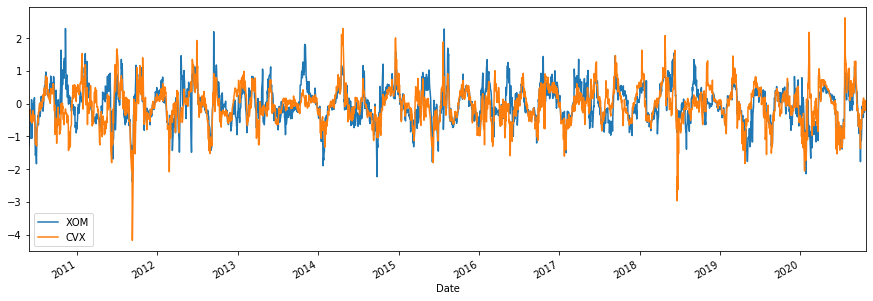

In [84]:
ssc.plot(figsize=(15,5))

We short when our zscore is under -1.25 and buy when the zscore is over 1.25.Moreover we keep the positions when the zscore is more than 0.5 for a buy or less than -0.5 for a short.

In [85]:
w1=0
w2=0
W_buy=[]
W_short=[]
idxbl=[]
idxsl=[]
registred_date_buy=0
registred_date_sell=0
sell='NA'
buy='NA'
for i in (ssc.index).strftime('%Y-%m-%d'):
    weight=1-w1-w2
    if ssc.loc[i][0]<-1.25 and weight>=0.50:
        w1=1
        registred_date_buy=i
        #PF=PF+w1*tech_s['AAPL'].pct_change()
        buy='yes'
    elif ssc.loc[i][0] > 1.25 and weight>0.50:
        w2=-0.50
        registred_date_sell=i
        #PF=PF+w2*tech_s['AAPL'].pct_change()
        sell='yes'
    elif buy=='yes' and ssc.loc[i][0]>-0.50:
        WUP=w1*df['CVX'].pct_change().loc[registred_date_buy:i]
        idxb=WUP.index
        WUP=WUP.values
        W_buy.extend(WUP)
        idxbl.extend(idxb)
        w1=0
        buy='No'
    elif sell=='yes' and ssc.loc[i][0]<0.75:
        WDWN=(w2*df['CVX'].pct_change().loc[registred_date_sell:i])
        idxs=WDWN.index
        WDWN=WDWN.values
        idxsl.extend(idxs)
        W_short.extend(WDWN)
        w2=0
        sell='No'
    
        

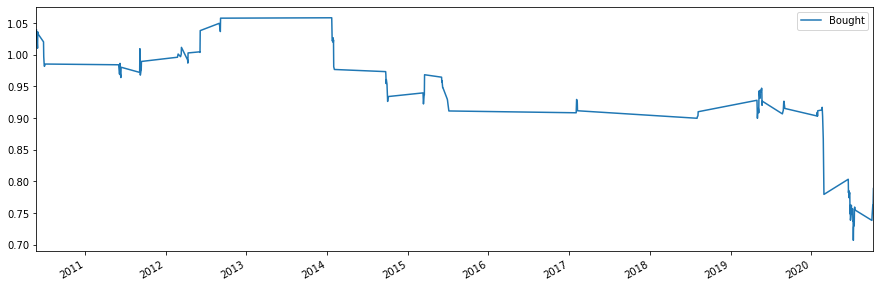

In [86]:
#cumulative return trading stock XOM under mean reversion 
assets_bought=pd.DataFrame(W_buy)
assets_bought.index=idxbl
assets_bought.columns = ['Bought']
assets_sold=pd.DataFrame(W_short)
assets_sold.columns = ['Sold']
assets_sold.index=idxsl

(1+assets_bought).cumprod().plot(figsize=(15,5))
plt.show()
#Buy strategy

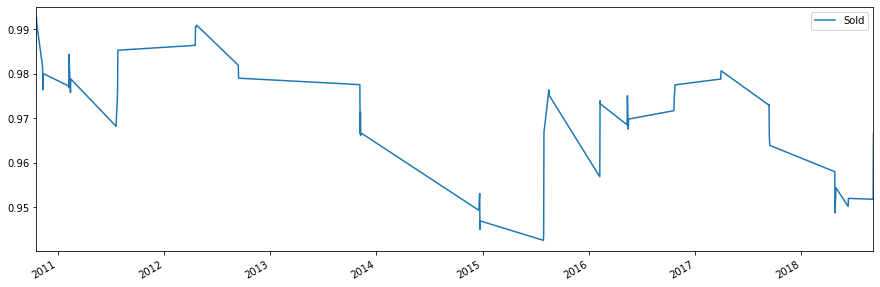

In [87]:
(1+assets_sold).cumprod().plot(figsize=(15,5))
plt.show()
#short strategy